In [ ]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.4 MB/s eta 0:00:00


In [ ]:
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 20.3 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376102 sha256=0315b938a26b6b9619ebc61772b8185cb04417476ba4c9588b8272b36a20db19
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.0
    Uninstalling pygame-2.6.0:
      Successfully uninstalled pygame-2.6.0



**1) SARSA**

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Episode 100	Average Score: -88.08
Episode 200	Average Score: 9.99
Episode 300	Average Score: 12.68
Episode 400	Average Score: 41.05
Episode 500	Average Score: 48.85


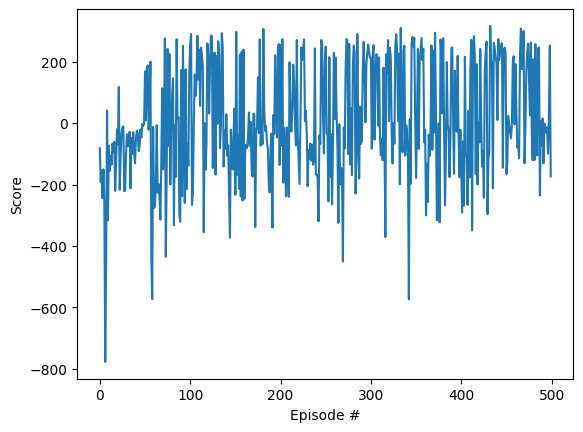

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Simple Q-Network architecture
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer (not typically used in SARSA, but can be adapted)
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, next_actions, dones = zip(*experiences)
        return (np.vstack(states), np.array(actions), np.array(rewards),
                np.vstack(next_states), np.array(next_actions), np.array(dones))

    def __len__(self):
        return len(self.memory)

# SARSA Agent
class SARSAAgent:
    def __init__(self, state_size, action_size, buffer_size=10000, batch_size=64, gamma=0.99, alpha=0.001, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.q_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)
        self.memory = ReplayBuffer(buffer_size, batch_size)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state)
            return np.argmax(q_values.cpu().data.numpy())

    def step(self, state, action, reward, next_state, next_action, done):
        self.memory.add((state, action, reward, next_state, next_action, done))
        if len(self.memory) > self.memory.batch_size:
            self.learn()

    def learn(self):
        states, actions, rewards, next_states, next_actions, dones = self.memory.sample()

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        next_actions = torch.LongTensor(next_actions).to(device)
        dones = torch.FloatTensor(dones).to(device)

        Q_expected = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        Q_targets_next = self.q_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        loss = nn.MSELoss()(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Training function
def train_sarsa(env, agent, n_episodes=500):
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        action = agent.get_action(state)
        score = 0
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = agent.get_action(next_state)
            agent.step(state, action, reward, next_state, next_action, done)
            state = next_state
            action = next_action
            score += reward
        scores_window.append(score)
        scores.append(score)
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tEpsilon: {agent.epsilon:.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            break
    return scores

# Main script
if __name__ == "__main__":
    env = gym.make('LunarLander-v2')
    env.seed(0)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    agent = SARSAAgent(state_size, action_size)
    scores = train_sarsa(env, agent)

    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()


**2) Q-learning**

Episode 100	Average Score: -167.43
Episode 200	Average Score: -144.79
Episode 300	Average Score: -146.89
Episode 400	Average Score: -184.17
Episode 500	Average Score: -198.34


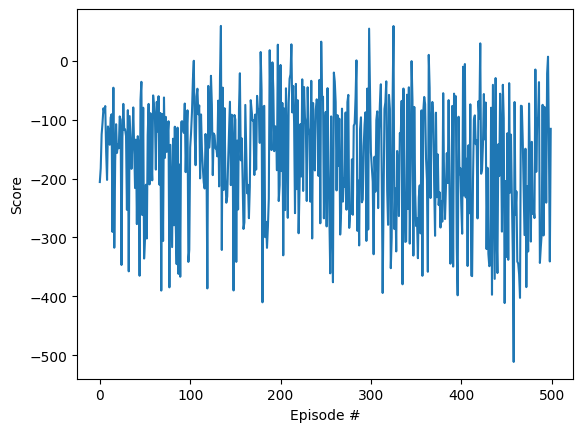

In [ ]:
import numpy as np
import gym
from collections import defaultdict, deque
import matplotlib.pyplot as plt

# Discretization helper functions
def create_bins(low, high, num_bins):
    return np.linspace(low, high, num_bins + 1)[1:-1]

def discretize_state(state, bins):
    return tuple(np.digitize(s, b) for s, b in zip(state, bins))

# Q-learning agent
class QLearningAgent:
    def __init__(self, state_bins, action_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_bins = state_bins
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_table = defaultdict(lambda: np.zeros(action_size))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            discretized_state = discretize_state(state, self.state_bins)
            return np.argmax(self.q_table[discretized_state])

    def update_q_table(self, state, action, reward, next_state, done):
        discretized_state = discretize_state(state, self.state_bins)
        discretized_next_state = discretize_state(next_state, self.state_bins)

        best_next_action = np.argmax(self.q_table[discretized_next_state])
        td_target = reward + self.gamma * self.q_table[discretized_next_state][best_next_action] * (1 - done)
        td_error = td_target - self.q_table[discretized_state][action]

        self.q_table[discretized_state][action] += self.alpha * td_error

        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Training function
def train_q_learning(env, agent, n_episodes=500, max_t=1000):
    scores = []
    scores_window = deque(maxlen=100)

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.get_action(state)
            step_result = env.step(action)
            next_state, reward, done = step_result[0], step_result[1], step_result[2]
            agent.update_q_table(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)

        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            break

    return scores

# Main script
if __name__ == "__main__":
    env = gym.make('LunarLander-v2')
    env.seed(0)

    # Create bins for discretizing the state space
    state_bins = [
        create_bins(-1.5, 1.5, 10),  # x-coordinate
        create_bins(-.5, 1.5, 10),   # y-coordinate
        create_bins(-1.0, 1.0, 10),  # x-velocity
        create_bins(-1.0, 1.0, 10),  # y-velocity
        create_bins(-3.14, 3.14, 10),# angle
        create_bins(-5.0, 5.0, 10),  # angular velocity
        create_bins(0.0, 1.0, 2),    # left leg contact
        create_bins(0.0, 1.0, 2)     # right leg contact
    ]

    action_size = env.action_space.n
    agent = QLearningAgent(state_bins, action_size)
    scores = train_q_learning(env, agent)

    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()


In [ ]:
import torch

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**3) Monte Carlo**

**4) DQN**

**5) DDQN**


In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, defaultdict
import matplotlib.pyplot as plt

# Discretization helper functions for Monte Carlo
def create_bins(low, high, num_bins):
    return np.linspace(low, high, num_bins + 1)[1:-1]

def discretize_state(state, bins):
    return tuple(np.digitize(s, b) for s, b in zip(state, bins))

# Neural Network for DQN/DDQN
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer for DQN/DDQN
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (np.vstack(states), np.array(actions), np.array(rewards),
                np.vstack(next_states), np.array(dones))

    def __len__(self):
        return len(self.memory)

# Monte Carlo Agent
class MCAgent:
    def __init__(self, state_bins, action_size, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_bins = state_bins
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(float)
        self.q_table = defaultdict(lambda: np.zeros(action_size))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            discretized_state = discretize_state(state, self.state_bins)
            return np.argmax(self.q_table[discretized_state])

    def update_q_table(self, episode):
        G = 0
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            discretized_state = discretize_state(state, self.state_bins)
            self.returns_sum[(discretized_state, action)] += G
            self.returns_count[(discretized_state, action)] += 1
            self.q_table[discretized_state][action] = self.returns_sum[(discretized_state, action)] / self.returns_count[(discretized_state, action)]
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# DQN/DDQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size=10000, batch_size=64, gamma=0.99, alpha=0.001, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, double_dqn=False):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.double_dqn = double_dqn

        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)
        self.memory = ReplayBuffer(buffer_size, batch_size)
        self.tau = 1e-3

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state)
            return np.argmax(q_values.cpu().data.numpy())

    def step(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))
        if len(self.memory) > self.memory.batch_size:
            self.learn()

    def learn(self):
        states, actions, rewards, next_states, dones = self.memory.sample()

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        Q_expected = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        if self.double_dqn:
            next_actions = self.q_network(next_states).argmax(1)
            Q_targets_next = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            Q_targets_next = self.target_network(next_states).max(1)[0]

        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        loss = nn.MSELoss()(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.q_network, self.target_network)

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

# Training functions
def train_mc(env, agent, n_episodes=500):
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        episode = []
        done = False
        score = 0
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            score += reward
        agent.update_q_table(episode)
        scores.append(score)
        print(f'\rEpisode {i_episode}\tScore: {score:.2f}\tEpsilon: {agent.epsilon:.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores[-100:]):.2f}')
    return scores

def train_dqn(env, agent, n_episodes=500):
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
        scores_window.append(score)
        scores.append(score)
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tEpsilon: {agent.epsilon:.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            break
    return scores





Episode 100	Average Score: -142.48
Episode 200	Average Score: -136.18
Episode 300	Average Score: -126.46
Episode 400	Average Score: -89.43
Episode 500	Average Score: -79.90


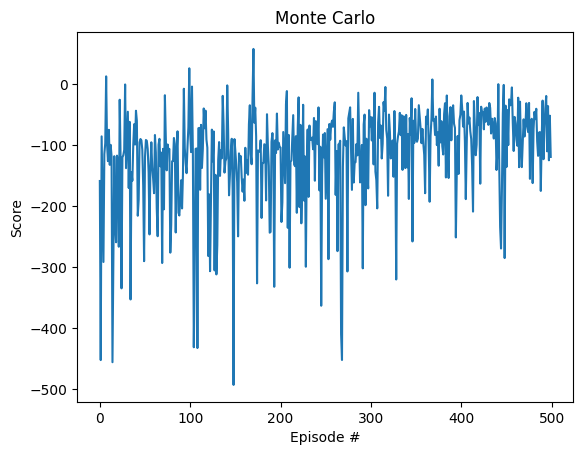

Episode 100	Average Score: -110.98
Episode 200	Average Score: -140.15
Episode 300	Average Score: -189.27
Episode 400	Average Score: -132.85
Episode 500	Average Score: -108.24


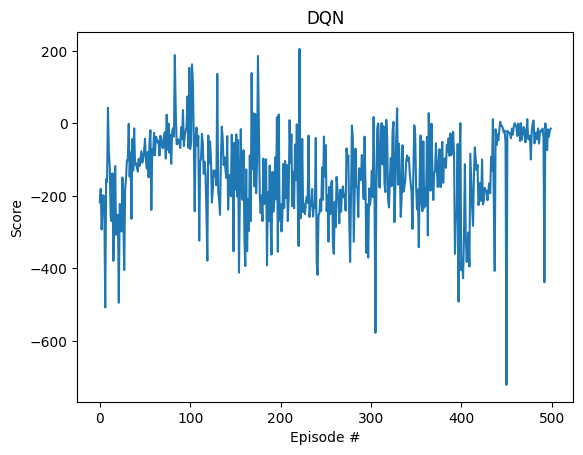

Episode 100	Average Score: -175.81
Episode 200	Average Score: -69.01
Episode 300	Average Score: -2.62
Episode 400	Average Score: 141.65
Episode 500	Average Score: 86.00


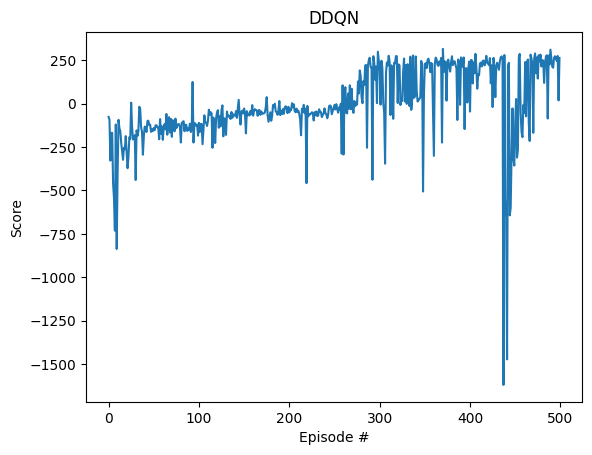

In [ ]:
# Main script
if __name__ == "__main__":
    env = gym.make('LunarLander-v2')
    env.seed(0)

    # Monte Carlo
    state_bins = [
        create_bins(-1.5, 1.5, 10),  # x-coordinate
        create_bins(-.5, 1.5, 10),   # y-coordinate
        create_bins(-1.0, 1.0, 10),  # x-velocity
        create_bins(-1.0, 1.0, 10),  # y-velocity
        create_bins(-3.14, 3.14, 10),# angle
        create_bins(-5.0, 5.0, 10),  # angular velocity
        create_bins(0.0, 1.0, 2),    # left leg contact
        create_bins(0.0, 1.0, 2)     # right leg contact
    ]

    action_size = env.action_space.n
    mc_agent = MCAgent(state_bins, action_size)
    mc_scores = train_mc(env, mc_agent)

    # Plot Monte Carlo results
    plt.plot(np.arange(len(mc_scores)), mc_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title('Monte Carlo')
    plt.show()
    # DQN
    state_size = env.observation_space.shape[0]
    dqn_agent = DQNAgent(state_size, action_size, double_dqn=False)
    dqn_scores = train_dqn(env, dqn_agent)

    # Plot DQN results
    plt.plot(np.arange(len(dqn_scores)), dqn_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title('DQN')
    plt.show()

    # DDQN
    ddqn_agent = DQNAgent(state_size, action_size, double_dqn=True)
    ddqn_scores = train_dqn(env, ddqn_agent)

    # Plot DDQN results
    plt.plot(np.arange(len(ddqn_scores)), ddqn_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title('DDQN')
    plt.show()


**6) Dueling Q-Network architecture**

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Episode 100	Average Score: -193.36
Episode 200	Average Score: -24.63
Episode 300	Average Score: 150.33
Episode 330	Average Score: 200.28	Epsilon: 0.01
Environment solved in 230 episodes!	Average Score: 200.28


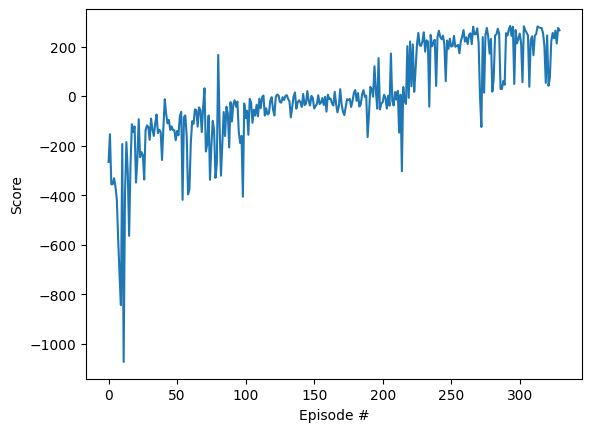

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Dueling Q-Network architecture
class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Separate streams for state value and advantage
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        q_value = value + (advantage - advantage.mean())
        return q_value

# Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (np.vstack(states), np.array(actions), np.array(rewards),
                np.vstack(next_states), np.array(dones))

    def __len__(self):
        return len(self.memory)

# Dueling DQN Agent
class DuelingDQNAgent:
    def __init__(self, state_size, action_size, buffer_size=10000, batch_size=64, gamma=0.99, alpha=0.001, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.q_network = DuelingQNetwork(state_size, action_size).to(device)
        self.target_network = DuelingQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)
        self.memory = ReplayBuffer(buffer_size, batch_size)
        self.tau = 1e-3

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state)
            return np.argmax(q_values.cpu().data.numpy())

    def step(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))
        if len(self.memory) > self.memory.batch_size:
            self.learn()

    def learn(self):
        states, actions, rewards, next_states, dones = self.memory.sample()

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        Q_expected = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        Q_targets_next = self.target_network(next_states).max(1)[0]
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        loss = nn.MSELoss()(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.q_network, self.target_network)

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

# Training function
def train_dueling_dqn(env, agent, n_episodes=500):
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
        scores_window.append(score)
        scores.append(score)
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tEpsilon: {agent.epsilon:.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            break
    return scores

# Main script
if __name__ == "__main__":
    env = gym.make('LunarLander-v2')
    env.seed(0)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    agent = DuelingDQNAgent(state_size, action_size)
    scores = train_dueling_dqn(env, agent)

    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
